In [1]:
# Imports
import torch
import torchvision
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
# Configs
plt.style.use('fivethirtyeight')
torch.manual_seed(0)
np.random.seed(0)
img_dir = './Data'
target_size = 64
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print("Cuda is unavailable")
    device = torch.device("cpu")

In [3]:
# Define our data loader
# https://pytorch.org/vision/stable/transforms.html
# TODO: consider adding noise as part of the transformation process
class ImageDataset(Dataset):
    def __init__(self, img_dir, target_size):
        self.img_dir = img_dir
        self.transform = v2.Compose([
            v2.Resize(size=(target_size, target_size), antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize (recommended for torch image datasets)
        ])
        self.imageLabels = os.listdir(img_dir)

    def __len__(self):
        return len(self.imageLabels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imageLabels[idx])
        image = torchvision.io.read_image(img_path)
        # label = self.imgLabels[idx]
        if self.transform:
            image = self.transform(image)
        return image

/tmp/ipykernel_11140/1111422179.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(np.rot90(img.T, k=3))


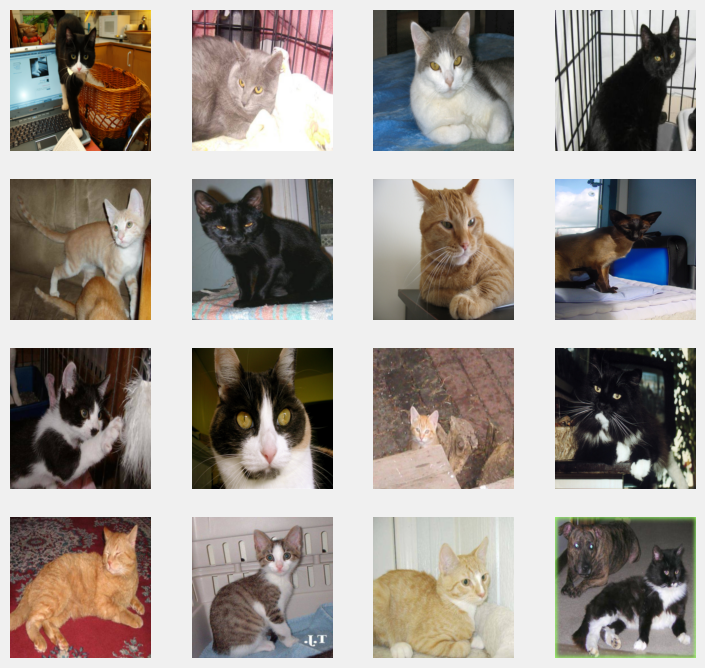

In [4]:
# Test the image loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
training_data = ImageDataset(img_dir, 256)

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(np.rot90(img.T, k=3))
plt.show()

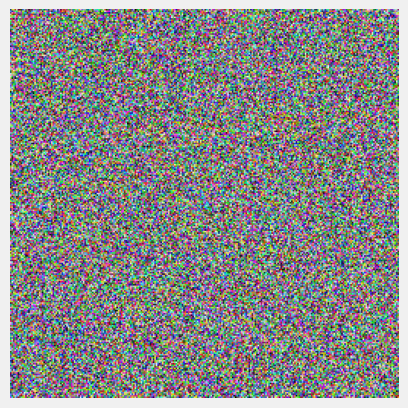

In [5]:
def generate_random_vector(shape: torch.Size):
    """
    Generate a random image with channels, width, and height defined by shape
    This is useful for testing that the discriminator can receive the correct inputs and outputs
    """
    channels = shape[0]
    width = shape[1]
    height = shape[2]
    return np.random.rand(channels, width, height)
img = generate_random_vector(training_data[0].shape)
plt.axis('off')
plt.imshow(np.rot90(img.T, k=3))

In [6]:
class WeightedLayer(torch.nn.Module):
    """
    Used to linearly combine two layers
    The first layer is multiplied by alpha, while the second is multiplied by 1-alpha
    """
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, x1, x2):
        return self.alpha * x1 + (1- self.alpha) * x2


In [7]:
# Test that the weighted layer is working correctly

# Test using two numbers
layer = WeightedLayer(alpha=0.9) # Take 90% of x and 10% of x2
assert(layer(10, 1) == 9.1)

# Test using two arrays
a = np.ones(shape=(2, 2))
b = np.zeros(shape=(2, 2))
assert(np.all(layer(a,b) == 0.9))

In [31]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.resolution = 3
        self.layers = []
        

    def forward(self, x):        
        return self.nn(x)
    
    def double_size(self):
        self.add_layer_bundle()
        self.resolution *= 2

    # TODO: This is the big thing that isn't working right now, the layers are coming out in the wrong order
    def add_layer_bundle(self):
        """
        A layer bundle consists of a Conv2D, a BatchNorm, and a ReLU
        each is added to the end of layers
        """
        # in_channels = self.resolution
        # out_channels = self.resolution // 2
        in_channels = self.resolution
        out_channels = self.resolution * 2
        ConvLayer = torch.nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=0, dilation=1, groups=1, bias=True)
        BatchNormLayer = torch.nn.BatchNorm2d(out_channels)
        ReLULayer = torch.nn.ReLU()
        
        self.layers.append(ConvLayer)
        self.layers.append(BatchNormLayer)
        self.layers.append(ReLULayer)
    def finalize_model(self):
        self.nn = torch.nn.Sequential()
        for count, layer in enumerate(self.layers):
            self.nn.add_module(str(count), layer)
        
        self.nn.add_module("FinalConv", torch.nn.Conv2d(self.resolution, 1, kernel_size=4))
        self.nn.add_module("Sigmoid", torch.nn.Sigmoid())
        self.nn = self.nn.to(device)
    def display_model(self):
        print(f"Resolution {self.resolution}")
        for layer in self.nn:
            print(layer)


In [32]:
discriminator = Discriminator().to(device)
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.finalize_model()
discriminator.double_size()
discriminator.finalize_model()
discriminator.display_model()

Resolution 384
Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(12, 24, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(24, 48, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(48, 96, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(96, 192, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(192, 384, kernel_size=(4, 4), stride=(1, 1))
BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(384, 1, kernel_siz

In [33]:
# Verify that the model can correctly handle the input images
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

discriminator.apply(weights_init)
discriminator.zero_grad()
# Format batch
real_cpu = training_data[0].to(device)
# Forward pass real batch through D
output = discriminator(real_cpu.unsqueeze(0)).view(-1)
output

tensor([0.5960, 0.6320, 0.6312,  ..., 0.6932, 0.7099, 0.5804], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [ ]:
class Generator:
    def __init__(self):
        pass